In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

import pickle
import os
import random

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import collections

In [3]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [4]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
    return codones

In [5]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [6]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

reading data/all_codones.pickle


In [7]:
len(all_codones)

972054

In [8]:
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 9000

def flatten(x):
    return [item for sublist in x for item in sublist]

def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
        unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(flatten(all_codones),
                                                            vocabulary_size)

In [9]:
#del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

Most common words (+UNK) [['UNK', 137373126], ('AAA', 152576), ('LLL', 131965), ('ALA', 127540), ('LAA', 126274)]
Sample data [4302, 767, 154, 3031, 2278, 4107, 9, 10, 4268, 4374] ['MAF', 'SAE', 'DVL', 'KEY', 'DRR', 'RRM', 'EAL', 'LLS', 'LYY', 'PND']


In [10]:
# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        if data_index == len(data):
            buffer[:] = data[:span]
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [13]:
# Step 4: Build and train a skip-gram model.

batch_size = 130
embedding_size = 100  # Dimension of the embedding vector.
skip_window = 2       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 50  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 32    # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Look up embeddings for inputs.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 0.5
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.global_variables_initializer()

In [24]:
# Step 5: Begin training.
num_steps = 1000001
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.1)

with tf.Session(graph=graph, config=tf.ConfigProto(gpu_options=gpu_options)) as session:
    # We must initialize all variables before we use them.
    init.run()
    print('Initialized')

    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(
          batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0

    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  119.126029968
Average loss at step  2000 :  61.1495944575
Average loss at step  4000 :  25.8924007711
Average loss at step  6000 :  11.727699588
Average loss at step  8000 :  7.03665991879
Average loss at step  10000 :  4.34988836366
Average loss at step  12000 :  4.42586186707
Average loss at step  14000 :  4.53659113109
Average loss at step  16000 :  4.1681057359
Average loss at step  18000 :  3.99903420579
Average loss at step  20000 :  3.2787261517
Average loss at step  22000 :  3.54625270468
Average loss at step  24000 :  3.6601667673
Average loss at step  26000 :  3.80738984627
Average loss at step  28000 :  3.80188235402
Average loss at step  30000 :  3.92436711299
Average loss at step  32000 :  3.87874091816
Average loss at step  34000 :  3.42209392667
Average loss at step  36000 :  2.61261815296
Average loss at step  38000 :  3.26761925304
Average loss at step  40000 :  4.06432568169
Average loss at step  42000 :  3.99964493847
Average lo

Average loss at step  360000 :  2.63819637197
Average loss at step  362000 :  2.98502131158
Average loss at step  364000 :  4.05092249942
Average loss at step  366000 :  3.95739364934
Average loss at step  368000 :  3.84283522844
Average loss at step  370000 :  3.70203513646
Average loss at step  372000 :  3.66868379104
Average loss at step  374000 :  3.4091258831
Average loss at step  376000 :  4.06076966739
Average loss at step  378000 :  4.0926863215
Average loss at step  380000 :  3.96751191795
Average loss at step  382000 :  3.74349420786
Average loss at step  384000 :  2.95387060857
Average loss at step  386000 :  3.24166875076
Average loss at step  388000 :  3.91270519984
Average loss at step  390000 :  3.95668291235
Average loss at step  392000 :  3.65617422414
Average loss at step  394000 :  2.56673428872
Average loss at step  396000 :  3.8659454838
Average loss at step  398000 :  3.87266151071
Average loss at step  400000 :  4.03922977996
Average loss at step  402000 :  3.946

Average loss at step  718000 :  3.80606846631
Average loss at step  720000 :  3.99840133929
Average loss at step  722000 :  4.09281390643
Average loss at step  724000 :  3.81891062462
Average loss at step  726000 :  3.92831310713
Average loss at step  728000 :  3.77012417293
Average loss at step  730000 :  3.67117787617
Average loss at step  732000 :  3.46938789392
Average loss at step  734000 :  3.53024798489
Average loss at step  736000 :  3.37046450347
Average loss at step  738000 :  3.57182955229
Average loss at step  740000 :  4.03005469978
Average loss at step  742000 :  3.74208204532
Average loss at step  744000 :  3.9628334564
Average loss at step  746000 :  3.76446300036
Average loss at step  748000 :  3.97897696114
Average loss at step  750000 :  3.29946661222
Average loss at step  752000 :  3.2122924124
Average loss at step  754000 :  3.75051852274
Average loss at step  756000 :  3.95314256883
Average loss at step  758000 :  3.75137947899
Average loss at step  760000 :  3.85

In [25]:
final_embeddings

array([[ 0.10082047, -0.18633492, -0.13755505, ..., -0.03174205,
         0.13989469, -0.11684187],
       [-0.08840837, -0.03059632, -0.00652557, ..., -0.05839119,
         0.06080177, -0.13072729],
       [-0.11391483, -0.00997427,  0.04847915, ..., -0.17545949,
         0.05758522, -0.10118128],
       ..., 
       [-0.05109098,  0.07239907,  0.12829277, ..., -0.05017259,
        -0.12748541,  0.10859746],
       [ 0.05100953,  0.04071346, -0.00584286, ...,  0.06296492,
         0.008503  ,  0.14932406],
       [-0.02431265,  0.10759754,  0.06825366, ...,  0.13342872,
        -0.02238155,  0.14059585]], dtype=float32)

In [26]:
tsne = TSNE(n_components=2, random_state=42)
XX = tsne.fit_transform(final_embeddings)

In [27]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(dictionary, key=dictionary.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

,x0,x1,codone
0,-0.626161,-1.229317,UNK
1,-0.566174,0.541346,AAA
2,-2.262350,-0.848446,LLL
3,-0.223504,-1.765902,ALA
4,-0.537833,0.245597,LAA


In [28]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [29]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [30]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

all_acid_df = pd.DataFrame(all_acid_dicts)
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')

reading data/all_acid_dicts.pickle


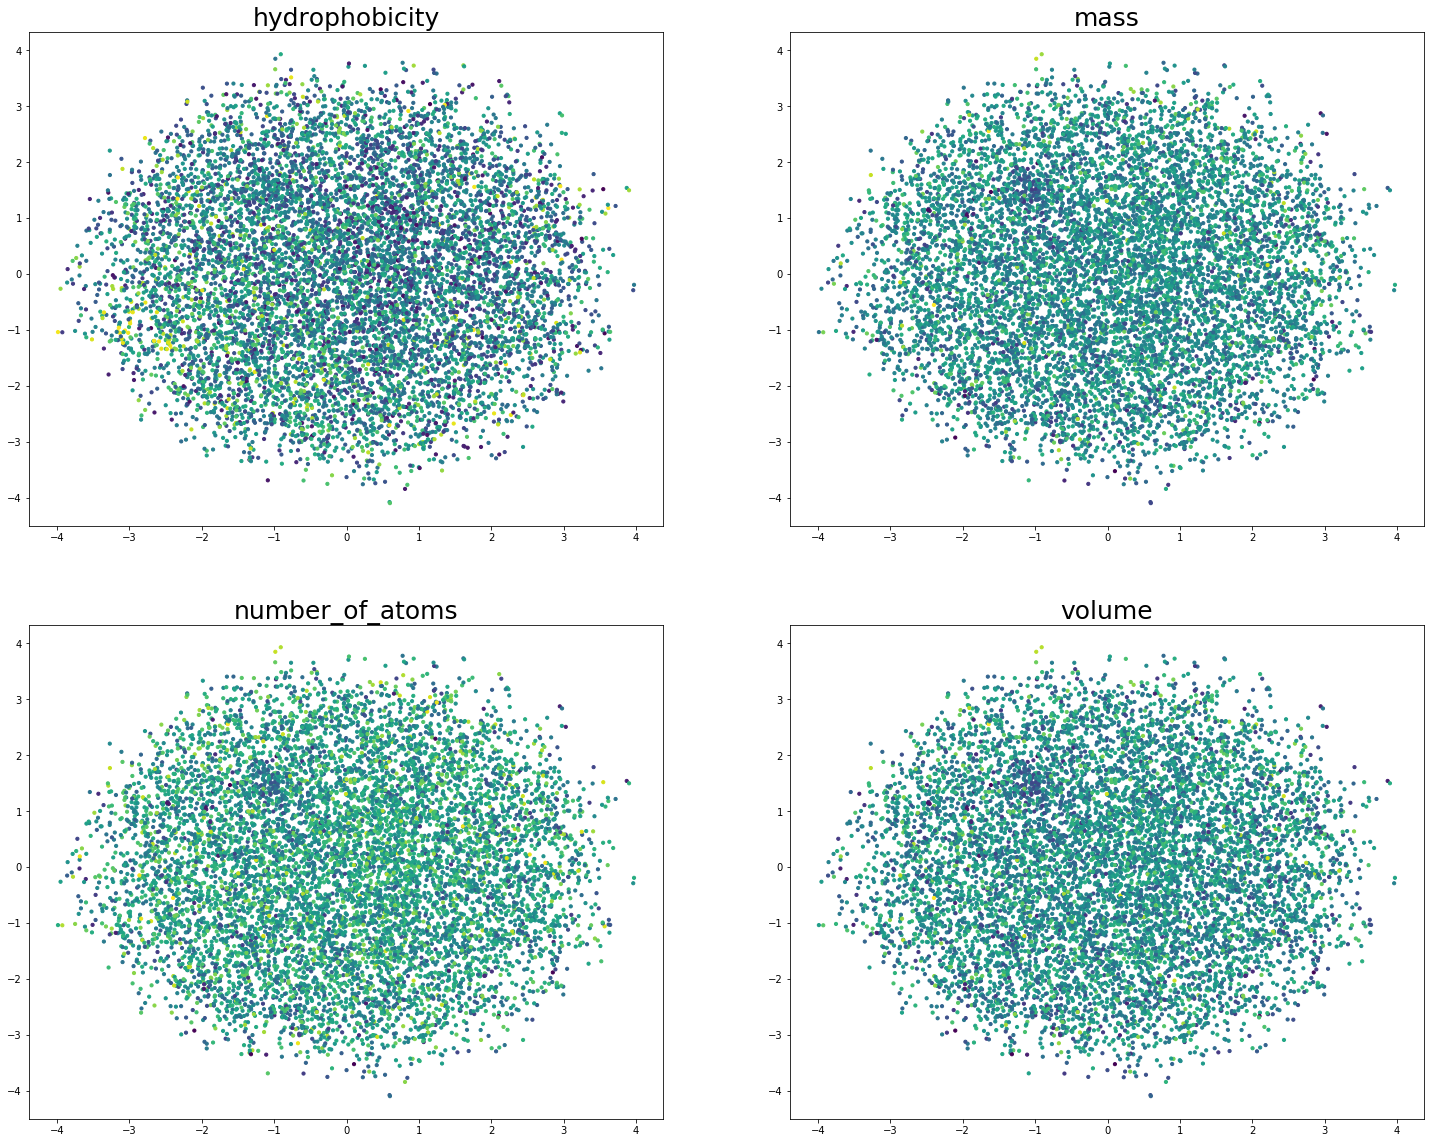

In [31]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

plot_embedding_properties(final_df)